In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_b0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define dataset path
data_path = "/kaggle/input/flower-color-images"

# Define transformations (Resizing, Normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit pretrained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [3]:
# Load the entire dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Define train-validation split ratio
train_size = int(0.8 * len(full_dataset))  # 80% training data
val_size = len(full_dataset) - train_size  # 20% validation data

# Split dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Get number of classes
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_size}, Validation samples: {val_size}")

Number of classes: 2
Training samples: 650, Validation samples: 163


In [4]:
from torchvision.models import densenet121

# Load a pretrained DenseNet121 model
model = densenet121(pretrained=True)

# Modify the classifier layer
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 146MB/s] 


In [5]:
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    train_losses = []  # Store training loss per epoch
    val_losses = []  # Store validation loss per epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get predicted classes
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Compute Average Train Loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_acc = 100. * correct / total
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Validation Loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Compute Average Validation Loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_acc = 100. * correct / total
        print(f"Epoch {epoch+1}: Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1: Train Loss: 0.4557, Train Acc: 73.08%
Epoch 1: Val Loss: 0.7062, Val Acc: 50.92%

Epoch 2: Train Loss: 0.4771, Train Acc: 73.69%
Epoch 2: Val Loss: 0.5647, Val Acc: 60.12%

Epoch 3: Train Loss: 0.4341, Train Acc: 75.69%
Epoch 3: Val Loss: 0.5999, Val Acc: 62.58%

Epoch 4: Train Loss: 0.4554, Train Acc: 73.38%
Epoch 4: Val Loss: 0.6230, Val Acc: 57.06%

Epoch 5: Train Loss: 0.4504, Train Acc: 73.23%
Epoch 5: Val Loss: 0.5631, Val Acc: 65.03%

Epoch 6: Train Loss: 0.4427, Train Acc: 73.69%
Epoch 6: Val Loss: 0.7569, Val Acc: 57.06%

Epoch 7: Train Loss: 0.4520, Train Acc: 75.54%
Epoch 7: Val Loss: 0.5691, Val Acc: 65.64%

Epoch 8: Train Loss: 0.4534, Train Acc: 74.31%
Epoch 8: Val Loss: 0.6777, Val Acc: 59.51%

Epoch 9: Train Loss: 0.4515, Train Acc: 74.46%
Epoch 9: Val Loss: 0.6689, Val Acc: 66.87%

Epoch 10: Train Loss: 0.4593, Train Acc: 74.15%
Epoch 10: Val Loss: 0.5922, Val Acc: 57.67%

Epoch 11: Train Loss: 0.4239, Train Acc: 74.46%
Epoch 11: Val Loss: 0.6485, Val Acc: 55.

In [13]:
torch.save(model.state_dict(), "flowers-recognition")
print("Model saved successfully!")

Model saved successfully!


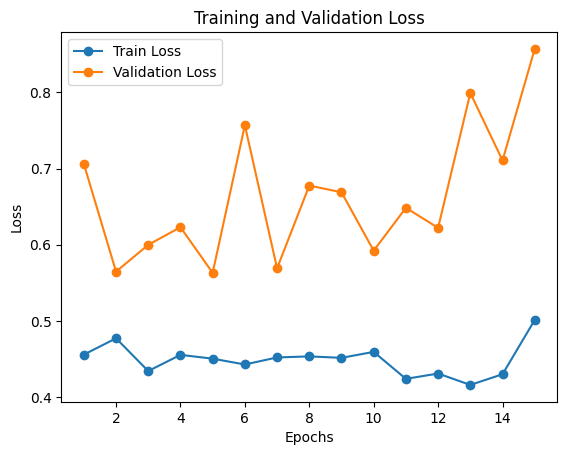

In [14]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, classes):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    # Generate classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Validation Accuracy: 74.23%

Classification Report:
                precision    recall  f1-score   support

flower_images       0.33      0.05      0.09        40
      flowers       0.76      0.97      0.85       123

     accuracy                           0.74       163
    macro avg       0.55      0.51      0.47       163
 weighted avg       0.65      0.74      0.66       163



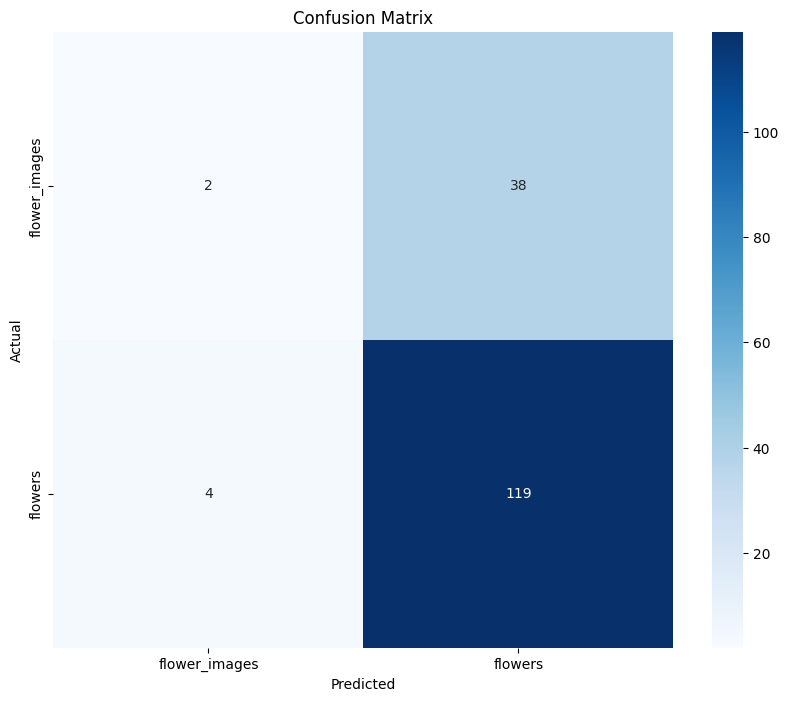

In [16]:
evaluate_model(model, val_loader, train_dataset.dataset.classes)